In [1]:
!pip install openai
!pip install langchain
!pip install eodhd
!pip install config

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.3 MB/s eta 0:00:00a 0:00:01
  Using cached aiohttp-3.9.5-cp39-cp39-macosx_11_0_arm64.whl.metadata (7.5 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp39-cp39-macosx_11_0_arm64.whl

In [3]:
!pip install langchain-community langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.0 MB/s eta 0:00:00


In [4]:
import re
import requests
import pandas as pd
import config as cfg
from eodhd import APIClient
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI

In [8]:
import pandas as pd
import numpy as np
import nltk
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords

combined_news_djia = pd.read_csv('../data/Combined_News_DJIA.csv')
for i in range(1, 25):
    combined_news_djia[f'Top{i}'] = combined_news_djia[f'Top{i}'].apply(str)
    combined_news_djia[f'Top{i}'].apply(lambda x: x[2:-1] if x[0]=='b' else x)
    

data = pd.DataFrame(columns=['Date', 'Text'])

data['Date'] = combined_news_djia['Date']
data['Text'] = combined_news_djia['Top1']

for i in range(1, 25):
    data['Text'] = data['Text'] + " " + combined_news_djia[f'Top{i}']


data = data.set_index('Date')

nltk.download('stopwords')
tokenizer = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

def process_headline(x):
    x = str(x)
    return " ".join([w.lower() for w in tokenizer.tokenize(x) if not w.lower() in stop_words])

data['Text'] = data['Text'].apply(process_headline)
data

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ignatiocalvin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text
Date,
2008-08-08,"b "" georgia ' downs two russian warplanes ' co..."
2008-08-11,"b ' wont america nato help us ? wont help us ,..."
2008-08-12,b ' remember adorable 9 - year - old sang open...
2008-08-13,b ' u . . refuses israel weapons attack iran :...
2008-08-14,b ' experts admit legalise drugs ' b ' experts...
...,...
2016-06-27,barclays rbs shares suspended trading tanking ...
2016-06-28,"2 , 500 scientists australia : want save great..."
2016-06-29,explosion airport istanbul explosion airport i...


In [12]:
llm = ChatOpenAI(model = "gpt-3.5-turbo",
                 openai_api_key = '', 
                 temperature = 0)

In [13]:
template = """
Identify the sentiment towards the Dow Jones (DJIA) stocks from the news article , where the sentiment score should be from -10 to +10 where -10 being the most negative and +10 being the most positve , and 0 being neutral

Also give the proper explanation for your answers and how would it effect the prices of different stocks

Article : {statement}
"""

# forming prompt using Langchain PromptTemplate functionality
prompt = PromptTemplate(template = template, input_variables = ["statement"])
llm_chain = LLMChain(prompt = prompt, llm = llm)

In [14]:
print(llm_chain.run(data['Text'][13]))

/var/folders/nv/9r2j07yj4w7gpdqz5zp13j3m0000gn/T/ipykernel_62216/2885198212.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(llm_chain.run(data['Text'][13]))


The sentiment towards the Dow Jones (DJIA) stocks from this news article is likely to be negative. The article contains a lot of negative and concerning news stories such as suicide bombings, political unrest, military conflicts, and natural disasters. These types of events can create uncertainty and instability in the global markets, leading to a decrease in investor confidence and potentially causing stock prices to decline.

Investors may react to this negative sentiment by selling off their stocks, leading to a decrease in the overall value of the Dow Jones (DJIA) stocks. It is important for investors to closely monitor the news and global events that could impact the stock market and make informed decisions based on the current sentiment and market conditions.


In [15]:
# A function to count the number of tokens
def count_tokens(text):
    tokens = text.split()  
    return len(tokens)

In [18]:
# Applying the tokenization function to the DataFrame column
data['TokenCount'] = data['Text'].apply(count_tokens)
data

,Text,TokenCount
Date,,
2008-08-08,"b "" georgia ' downs two russian warplanes ' co...",385
2008-08-11,"b ' wont america nato help us ? wont help us ,...",283
2008-08-12,b ' remember adorable 9 - year - old sang open...,348
2008-08-13,b ' u . . refuses israel weapons attack iran :...,339
2008-08-14,b ' experts admit legalise drugs ' b ' experts...,297
...,...,...
2016-06-27,barclays rbs shares suspended trading tanking ...,328
2016-06-28,"2 , 500 scientists australia : want save great...",381
2016-06-29,explosion airport istanbul explosion airport i...,320


In [19]:
# Define a token count threshold (for example, keep rows with more than 2 tokens)
token_count_threshold = 3500

# Create a new DataFrame by filtering based on the token count
new_df = data[data['TokenCount'] < token_count_threshold]

# Drop the 'TokenCount' column from the new DataFrame if you don't need it
new_df = new_df.drop('TokenCount', axis = 1)

# Resetting the index
new_df = new_df.reset_index(drop = True)

In [20]:
template_2 = """
Identify the sentiment towards the Dow Jones (DJIA) stocks of the news article from -10 to +10 where -10 being the most negative and +10 being the most positve , and 0 being neutral

GIVE ANSWER IN ONLY ONE WORD AND THAT SHOULD BE THE SCORE

Article : {statement}
"""

# forming prompt using Langchain PromptTemplate functionality
prompt_2 = PromptTemplate(template = template_2, input_variables = ["statement"])


In [21]:
llm_chain_2 = LLMChain(prompt = prompt_2, llm = llm)

In [22]:
print(new_df['Text'][2])
print('')
print('News sentiment: ', llm_chain_2.run(new_df['Text'][2]))

b ' remember adorable 9 - year - old sang opening ceremonies ? fake , .' b ' remember adorable 9 - year - old sang opening ceremonies ? fake , .' b " russia ' ends georgia operation '" b '" sexual harassment would children ..."' b " al - qa ' eda losing support iraq brutal crackdown activities regards un - islamic - including women buying cucumbers " b ' ceasefire georgia : putin outmaneuvers west ' b ' microsoft intel tried kill xo $ 100 laptop ' b ' stratfor : russo - georgian war balance power ' b " ' trying get sense whole georgia - russia war : vote think georgia started , think russia " b " us military surprised timing swiftness russian military ' move south ossetia still trying sort happened , us defense official said monday " b ' u . . beats war drum iran dumps dollar ' b ' gorbachev : " georgian military attacked south ossetian capital tskhinvali multiple rocket launchers designed devastate large areas "' b ' cnn use footage tskhinvali ruins cover georgian report [ video ]' b 

In [23]:
x = []
for i in range(0,new_df.shape[0]):
    x.append(llm_chain_2.run(new_df['Text'][i]))

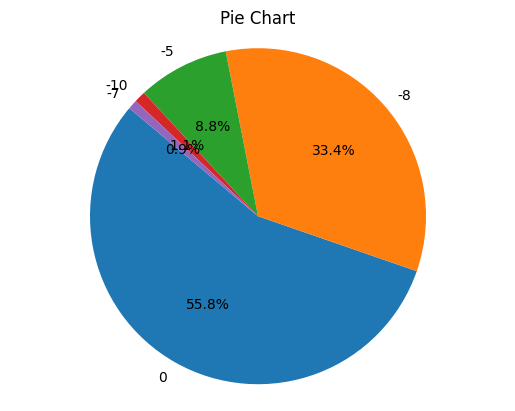

In [24]:
import matplotlib.pyplot as plt

dt = pd.DataFrame(x) # Converting into Dataframe
column_name = 0 # this is my column name you should change it according to your data
value_counts = dt[column_name].value_counts()

# Plotting the pie chart
plt.pie(value_counts, labels = value_counts.index, autopct = '%1.1f%%', startangle = 140)
plt.title(f'Pie Chart')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Show the pie chart
plt.show()

In [25]:
value_to_remove = '0'
# Remove all rows where the specified value occurs in the column
dt_new = dt[dt[0] != value_to_remove]

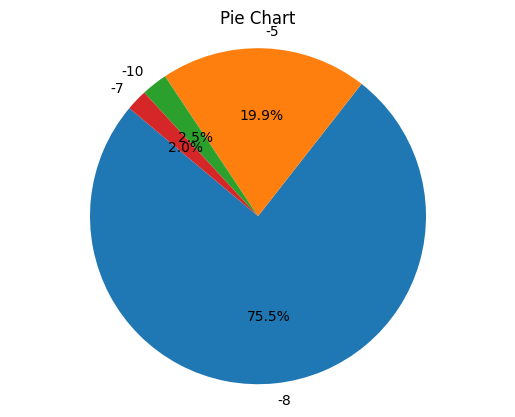

In [26]:
value_counts = dt_new[column_name].value_counts()

# Plotting the pie chart
plt.pie(value_counts, labels = value_counts.index, autopct = '%1.1f%%', startangle = 140)
plt.title(f'Pie Chart')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Show the pie chart
plt.show()

In [27]:
np.save('../fingpt_sentiment.npy', np.array(x))